In [1]:
import jax.numpy as np
from jax import vmap, grad, random, jit
from jax.example_libraries import optimizers
from jax.lax import scan, fori_loop
# from jax.ops import index, index_update

import itertools
from functools import partial
from tqdm import trange
from matplotlib import pyplot as plt

In [2]:
# Helper functions for visualizing the computational graph
import jax
from jax import core
from graphviz import Digraph
import itertools

styles = {
  'const': dict(style='filled', color='goldenrod1'),
  'invar': dict(color='mediumspringgreen', style='filled'),
  'outvar': dict(style='filled,dashed', fillcolor='indianred1', color='black'),
  'op_node': dict(shape='box', color='lightskyblue', style='filled'),
  'intermediate': dict(style='filled', color='cornflowerblue')
}

def _jaxpr_graph(jaxpr):
    id_names = (f'id{id}' for id in itertools.count())
    graph = Digraph(engine='dot')
    graph.attr(size='6,10!')
    for v in jaxpr.constvars:
        graph.node(str(v), core.raise_to_shaped(v.aval).str_short(), styles['const'])
    for v in jaxpr.invars:
        graph.node(str(v), v.aval.str_short(), styles['invar'])
    for eqn in jaxpr.eqns:
        for v in eqn.invars:
            if isinstance(v, core.Literal):
                graph.node(str(id(v.val)), core.raise_to_shaped(core.get_aval(v.val)).str_short(), styles['const'])
        if eqn.primitive.multiple_results:
            id_name = next(id_names)
            graph.node(id_name, str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), id_name)
            for v in eqn.outvars:
                graph.node(str(v), v.aval.str_short(), styles['intermediate'])
                graph.edge(id_name, str(v))
        else:
            outv, = eqn.outvars
            graph.node(str(outv), str(eqn.primitive), styles['op_node'])
            for v in eqn.invars:
                graph.edge(str(id(v.val) if isinstance(v, core.Literal) else v), str(outv))
    for i, v in enumerate(jaxpr.outvars):
        outv = 'out_'+str(i)
        graph.node(outv, outv, styles['outvar'])
        graph.edge(str(v), outv)
    return graph


def jaxpr_graph(fun, *args):
    jaxpr = jax.make_jaxpr(fun)(*args).jaxpr
    return _jaxpr_graph(jaxpr)


def grad_graph(fun, *args):
    _, fun_vjp = jax.vjp(fun, *args)
    jaxpr = fun_vjp.args[0].func.args[1]
    return _jaxpr_graph(jaxpr)

In [3]:
# Naive implementation via a 'for' loop
def RNN_naive(depth, dims, activation=np.tanh):
  input_dim, hidden_dim, output_dim = dims
  def init(rng_key):
      def glorot_init(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          return W
      keys = random.split(rng_key, 3)
      # Input layer
      U = glorot_init(keys[0], input_dim, hidden_dim)
      b = np.zeros(hidden_dim)
      # Transition dynamics
      W = glorot_init(keys[1], hidden_dim, hidden_dim)
      # Output layer
      V = glorot_init(keys[2], hidden_dim, output_dim)
      c = np.zeros(output_dim)
      return U, b, W, V, c
  def apply(params, inputs):
      U, b, W, V, c = params
      H = np.zeros((inputs.shape[1], hidden_dim))
      for i in range(depth):
          H = activation(np.dot(H,W) + np.dot(inputs[i,:,:],U) + b) 
      H = np.dot(H,V) + c
      return H
  return init, apply

# Efficient implementation via lax.scan
def RNN(depth, dims, activation=np.tanh):
  input_dim, hidden_dim, output_dim = dims
  def init(rng_key):
      def glorot_init(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          return W
      keys = random.split(rng_key, 3)
      # Input layer
      U = glorot_init(keys[0], input_dim, hidden_dim)
      b = np.zeros(hidden_dim)
      # Transition dynamics
      W = glorot_init(keys[1], hidden_dim, hidden_dim)
      # Output layer
      V = glorot_init(keys[2], hidden_dim, output_dim)
      c = np.zeros(output_dim)
      return U, b, W, V, c
  def scan_fn(params, H, inputs):
      U, b, W, _, _ = params
      H = activation(np.dot(H,W) + np.dot(inputs,U) + b) 
      return H, H
  def apply(params, inputs):
      _, _, _, V, c = params
      f = partial(scan_fn, params)
      H = np.zeros((inputs.shape[1], hidden_dim))
      H, _ = scan(f, H, inputs)
      H = np.dot(H,V) + c
      return H
  return init, apply

In [4]:
# Compare naive vs lax.scan implemenations
rng_key = random.PRNGKey(0)
depth = 10
dims = (2,32,2)
init, apply = RNN(depth, dims)
_, apply_naive = RNN_naive(depth, dims)
params = init(rng_key)
inputs = random.normal(rng_key, (depth, 128, dims[-1]))

In [5]:
%time out = apply_naive(params, inputs).block_until_ready()
%time out = apply(params, inputs).block_until_ready()

CPU times: user 509 ms, sys: 21 ms, total: 530 ms
Wall time: 1.61 s
CPU times: user 162 ms, sys: 3.9 ms, total: 166 ms
Wall time: 277 ms


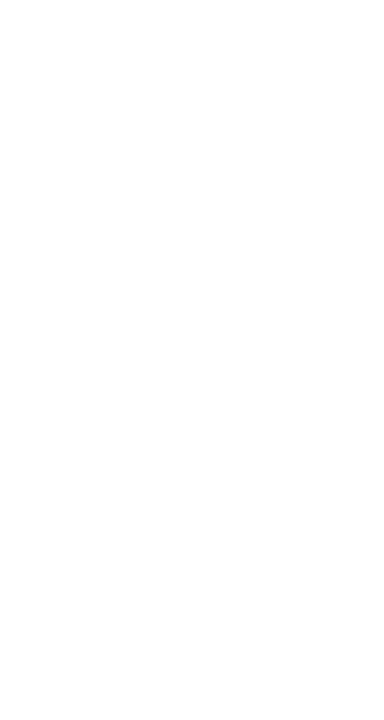

In [6]:
# The naive 'for-loop' implementation leads to a complex recursive computational graph
g1 = jaxpr_graph(apply_naive, params, inputs)
g1

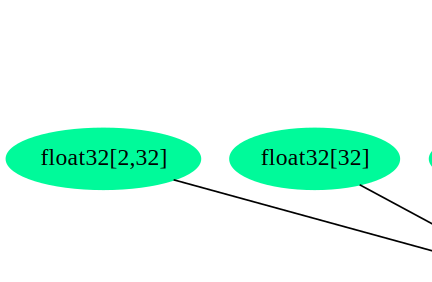

In [7]:
# The lax.scan implementation leads to a much simpler graph
g2 = jaxpr_graph(apply, params, inputs)
g2

In [8]:
class Seq2Seq:
    # Initialize the class
    def __init__(self, depth, dims, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = RNN(depth, dims)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets-outputs)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [9]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
    
    @partial(jit, static_argnums=(0,))  
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[:,idx,:]
        targets = Y[idx,:]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [10]:
def create_lags(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(N):
        X = X.at[:,i,:].set(data[i:(i+lags),:])
        Y = Y.at[i,:].set(data[i+lags,:])
    return X, Y

# Ground truth signal
def f(t):
    f = np.sin(np.pi*t) + np.sin(0.5*np.pi*t) 
    return f

# Create time-series data
t = np.arange(0,50,0.1)[:,None]
data = f(t)

# Normalize
mu, std = data.mean(0), data.std(0)
norm_data = (data - mu)/std

# Use 2/3 of all data as training Data
train_size = int(len(norm_data) * (2.0/3.0))
training_data = norm_data[0:train_size,:]

# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X, Y = create_lags(training_data, lags)
dataset = DataGenerator(X, Y, batch_size=128)

In [11]:
# Initialize model
inp_dim = X.shape[-1]
out_dim = Y.shape[-1]
hid_dim = 50
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))

100%|██████████| 20000/20000 [01:25<00:00, 234.70it/s, Loss=5.4440225e-06]


Text(0, 0.5, 'Loss')

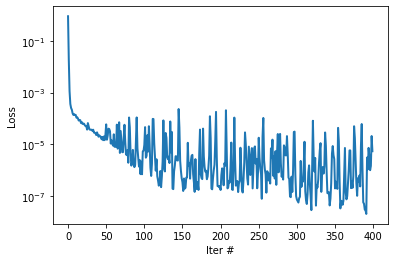

In [12]:
# Train model
model.train(dataset, nIter=20000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [13]:
# One-step-ahead prediction via lax.scan
def one_step_pred(inputs, step):
      outputs = model.predict(opt_params, inputs)
      inputs = inputs.at[:-1,...].set(inputs[1:,...])
      inputs = inputs.at[-1,...].set(outputs)
      return inputs, outputs[-1,:]

steps = len(norm_data)-lags
_, outputs = scan(one_step_pred, X[:,0:1,:], np.arange(steps))

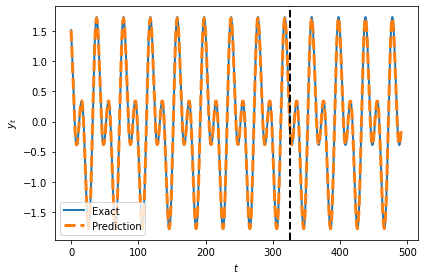

In [14]:
plt.figure()
plt.plot(norm_data[lags:], '-', lw = 2, label = "Exact")
plt.plot(outputs, '--', lw = 3, label = "Prediction")
plt.axvline(X.shape[1], color='black', ls='--', lw=2)
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc='lower left')
plt.tight_layout()